<img width="800px" src="../fidle/img/00-Fidle-header-01.svg"></img>

# <!-- TITLE --> [VAE1] - First VAE, with a small dataset (MNIST)
<!-- DESC --> Construction and training of a VAE with a latent space of small dimension.

<!-- AUTHOR : Jean-Luc Parouty (CNRS/SIMaP) -->

## Objectives :
 - Understanding and implementing a **variational autoencoder** neurals network (VAE)
 - Understanding a more **advanced programming model**

The calculation needs being important, it is preferable to use a very simple dataset such as MNIST to start with.  
...MNIST with a small scale if you haven't a GPU ;-)

## What we're going to do :

 - Defining a VAE model
 - Build the model
 - Train it
 - Have a look on the train process

## Acknowledgements :
Thanks to **François Chollet** who is at the base of this example (and the creator of Keras !!).  
See : https://keras.io/examples/generative/vae


## Step 1 - Init python stuff

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import TensorBoard

from modules.models.VAE  import VAE
from modules.layers      import SamplingLayer, VariationalLossLayer
from modules.callbacks   import ImagesCallback, BestModelCallback
from modules.data        import MNIST

import sys
sys.path.append('..')
import fidle.pwk as pwk

run_dir = './run/VAE1.001'
datasets_dir = pwk.init('VAE1', run_dir)

VAE.about()

<br>**FIDLE 2020 - Practical Work Module**

Version              : 2.0.20
Notebook id          : VAE1
Run time             : Saturday 20 March 2021, 22:34:56
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf
Datasets dir         : /home/pjluc/datasets/fidle
Run dir              : ./run/VAE1.001
Update keras cache   : False


<br>**FIDLE 2021 - VAE**

Version              : 1.4
TensorFlow version   : 2.2.0
Keras version        : 2.3.0-tf


## Step 2 - Parameters
With scale=1 : 1'30s on a GPU V100 and >20' on a CPU...

In [2]:
latent_dim    = 2
loss_weights  = [3,7]
scale         = 0.1
batch_size    = 64
epochs        = 10

Override parameters (batch mode) - Just forget this cell

In [3]:
pwk.override('scale', 'latent_dim', 'r_loss_factor', 'batch_size', 'epochs')

## Step 3 - Prepare data
`MNIST.get_data()` return : `x_train,y_train, x_test,y_test`,  \
but we only need x_train for our training.

Seeded (123)
Dataset loaded.
Concatenated.
Shuffled.
rescaled (0.1).
Normalized.
Reshaped.
splited (0.8).
x_train shape is  :  (5600, 28, 28, 1)
x_test  shape is  :  (1400, 28, 28, 1)
y_train shape is  :  (5600,)
y_test  shape is  :  (1400,)
Blake2b digest is :  b92de405fade06d38f72


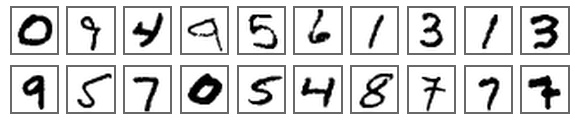

In [4]:
x_train, _, _, _ = MNIST.get_data(seed=123, scale=scale)

pwk.plot_images(x_train[:20], None, indices='all', columns=10, x_size=1,y_size=1,y_padding=0, save_as='01-original')

## Step 4 - Build model

#### Encoder

In [5]:
inputs    = keras.Input(shape=(28, 28, 1))
x         = layers.Conv2D(32, 3, strides=1, padding="same", activation="relu")(inputs)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=2, padding="same", activation="relu")(x)
x         = layers.Conv2D(64, 3, strides=1, padding="same", activation="relu")(x)
x         = layers.Flatten()(x)
x         = layers.Dense(16, activation="relu")(x)

z_mean    = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z         = SamplingLayer()([z_mean, z_log_var])

encoder = keras.Model(inputs, [z_mean, z_log_var, z], name="encoder")
# encoder.summary()

#### Decoder

In [6]:
inputs  = keras.Input(shape=(latent_dim,))
x       = layers.Dense(7 * 7 * 64, activation="relu")(inputs)
x       = layers.Reshape((7, 7, 64))(x)
x       = layers.Conv2DTranspose(64, 3, strides=1, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(64, 3, strides=2, padding="same", activation="relu")(x)
x       = layers.Conv2DTranspose(32, 3, strides=2, padding="same", activation="relu")(x)
outputs = layers.Conv2DTranspose(1,  3, padding="same", activation="sigmoid")(x)

decoder = keras.Model(inputs, outputs, name="decoder")

# decoder.summary()

#### VAE
Our loss function is the weighted sum of two values.  
`reconstruction_loss` which measures the loss during reconstruction.  
`kl_loss` which measures the dispersion.  

The weights are defined by: `loss_weights=[k1,k2]` where :  
`total_loss = k1*reconstruction_loss + k2*kl_loss`

In practice, a value of \[3,7\] gives good results here.


In [7]:

x    = keras.Input(shape=(28, 28, 1))

z_mean, z_log_var, z = encoder(x)
y = decoder(z)

y = VariationalLossLayer(loss_weights=[3,7])([x, z_mean, z_log_var, y])

vae=keras.Model(x,y)

vae.compile(optimizer='adam', loss=None)

## Step 5 - Train
### 5.1 - Add Nice callbacks, home made :-)

In [ ]:

# ---- Callback : Save images encoded/generated
#
callback_images = ImagesCallback(encoder=encoder,decoder=decoder, 
                                 x=x_train, z_dim=2, 
                                 nb_images=5, from_z=True, from_random=True, run_dir=run_dir)

# ---- Callback : Save best model
#
callback_bestmodel = BestModelCallback( run_dir + '/models/best_model' )

# ---- Callback : Tensorboard
#
callback_tensorboard = TensorBoard(log_dir=run_dir + '/logs', histogram_freq=1)

# callbacks_list = [callback_images, callback_bestmodel]
callbacks_list = [callback_images]

### 5.2 - Let's train !
With `scale=1`, need 1'15 on a GPU (V100 at IDRIS) ...or 20' on a CPU  

In [ ]:
pwk.chrono_start()

history = vae.fit(x_train, epochs=epochs, batch_size=batch_size, callbacks=callbacks_list,)

pwk.chrono_show()

## Step 6 - About our training session
### 6.1 - History

In [ ]:
pwk.plot_history(history,  plot={"Loss":['loss','r_loss', 'kl_loss']}, save_as='history')

### 6.2 - Reconstruction during training
At the end of each epoch, our callback saved some reconstructed images.  
Where :  
Original image -> encoder -> z -> decoder -> Reconstructed image

In [ ]:
images_z, images_r = callback_images.get_images( range(0,epochs,2) )

pwk.subtitle('Original images :')
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)

pwk.subtitle('Encoded/decoded images')
pwk.plot_images(images_r, None, indices='all', columns=5, x_size=2,y_size=2, save_as='02-reconstruct')

pwk.subtitle('Original images :')
pwk.plot_images(x_train[:5], None, indices='all', columns=5, x_size=2,y_size=2, save_as=None)


### 6.3 - Generation (latent -> decoder)

In [ ]:
pwk.subtitle('Generated images from latent space')
pwk.plot_images(images_z, None, indices='all', columns=5, x_size=2,y_size=2, save_as='03-encoded')

In [8]:
vae.save('foo.h5')
vae = keras.models.load_model('foo.h5', custom_objects={'SamplingLayer': SamplingLayer, 'VariationalLossLayer':VariationalLossLayer})

In [ ]:
pwk.end()

---
<img width="80px" src="../fidle/img/00-Fidle-logo-01.svg"></img>